In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras import optimizers
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from keras.layers import LSTM
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers import Masking
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed
import utm


class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch': [], 'epoch': []}
        self.accuracy = {'batch': [], 'epoch': []}
        self.val_loss = {'batch': [], 'epoch': []}
        self.val_acc = {'batch': [], 'epoch': []}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

data = pd.read_csv('trainfix.csv')
traj=data['TrajID'].values
ao=data[['Latitude','Longitude']].values.T

dataset = [
    np.array([[mr[4:9],
               mr[9:14],
               mr[14:19],
               mr[19:24],
               mr[24:29],
               mr[29:34]]]).T for mr in data.values
]

dataset = np.array(dataset)
label = pd.read_csv('label1.csv')['label'].values

labelset=to_categorical(label,891)

def build_model_cnn():
    m = Sequential()
    m.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(5, 6, 1)))
    m.add(Conv2D(64, kernel_size=3, activation='relu'))
    m.add(Flatten())
    m.add(Dense(1024, activation='relu'))
    m.add(Dropout(0.2))
    m.add(Dense(512, activation='relu'))
    m.add(Dropout(0.2))
    m.add(Dense(512, activation='relu'))
    m.add(Dropout(0.2))
    m.add(Dense(891, activation='softmax'))
    r = optimizers.Adam(lr=0.001)
    m.compile(optimizer=r, loss='categorical_crossentropy', metrics=['accuracy'])
    return m

def build_model_lstm():
    model=Sequential()
    model.add(LSTM(32,return_sequences=True,input_shape=(maxleng,891)))
    model.add(LSTM(64,return_sequences=True))
    model.add(Dense(1024))
    model.add(TimeDistributed(Dense(891)))
    model.add(Activation('softmax'))
    r = RMSprop(lr=0.001)
    model.compile(optimizer=r,loss='categorical_crossentropy',metrics=['accuracy'])
    return model


x_train,x_test, y_train, y_test = train_test_split(dataset, labelset, test_size=0.2, random_state=33)
model = build_model_cnn()
model.summary()
model.fit(dataset, labelset, epochs=200, batch_size=64)
# model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=200, batch_size=64)
predict=model.predict(dataset)
predict=pd.DataFrame(predict)
predict['TrajID']=traj
predict['Latitude']=ao[0]
predict['Longitude']=ao[1]
maxleng=6

tra=predict["TrajID"].unique()
datasetL=[]
labelsetL=[]
for i in tra:
       x=predict[predict["TrajID"]==i]
       value=[mr[0:891]for mr in x.values]
       datasetL.append(value)
       labelsetL.append(x[['Latitude','Longitude']].values)
datasetfix=[]
labelsetfix=[]
for i in range(len(datasetL)):
       count=len(datasetL[i])-maxleng+1
       for j in range(count):
              datasetfix.append(datasetL[i][j:j+maxleng])
              labelsetfix.append(labelsetL[i][j:j+maxleng])
datasetfix=np.array(datasetfix)
labelsetfix=np.array(labelsetfix)
X_train, X_test, y_train, y_test = train_test_split(datasetfix, labelsetfix, test_size=0.2, random_state=33)

grid=pd.read_csv('grid1.csv')[['x','y']].values
Y_train=[]
for seq in y_train:
    poses=[]
    for mr in seq:
        u1, u2, _, _ = utm.from_latlon(mr[0], mr[1])
        test = np.array([u1, u2])
        poses.append(np.argmin(np.sum(np.square(test - grid), axis=1)))
    Y_train.append(poses)

Y_train=to_categorical(np.array(Y_train),891)
Y_test=[]
y_test_utm=[]
for seq in y_test:
    poses=[]
    utms=[]
    for mr in seq:
        u1, u2, _, _ = utm.from_latlon(mr[0], mr[1])
        test = np.array([u1, u2])
        utms.append([u1, u2])
        poses.append(np.argmin(np.sum(np.square(test - grid), axis=1)))
    y_test_utm.append(utms)
    Y_test.append(poses)

Y_test=to_categorical(np.array(Y_test),891)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 4, 32)          320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 2, 64)          18496     
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              132096    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

10047/10047 [==============================] - 2s 151us/step - loss: 0.7044 - acc: 0.7504
Epoch 65/200
10047/10047 [==============================] - 2s 151us/step - loss: 0.6766 - acc: 0.7612
Epoch 66/200
10047/10047 [==============================] - 2s 150us/step - loss: 0.6950 - acc: 0.7586
Epoch 67/200
10047/10047 [==============================] - 2s 150us/step - loss: 0.6795 - acc: 0.7580
Epoch 68/200
10047/10047 [==============================] - 1s 141us/step - loss: 0.6647 - acc: 0.7640
Epoch 69/200
10047/10047 [==============================] - 1s 135us/step - loss: 0.6622 - acc: 0.7645
Epoch 70/200
10047/10047 [==============================] - 1s 137us/step - loss: 0.6555 - acc: 0.7643
Epoch 71/200
10047/10047 [==============================] - 1s 137us/step - loss: 0.6343 - acc: 0.7738
Epoch 72/200
10047/10047 [==============================] - 1s 135us/step - loss: 0.6232 - acc: 0.7749
Epoch 73/200
10047/10047 [==============================] - 1s 143us/step - loss: 0.62

10047/10047 [==============================] - 2s 152us/step - loss: 0.3821 - acc: 0.8555
Epoch 144/200
10047/10047 [==============================] - 2s 154us/step - loss: 0.3999 - acc: 0.8541
Epoch 145/200
10047/10047 [==============================] - 2s 150us/step - loss: 0.3907 - acc: 0.8551
Epoch 146/200
10047/10047 [==============================] - 2s 153us/step - loss: 0.3818 - acc: 0.8600
Epoch 147/200
10047/10047 [==============================] - 2s 151us/step - loss: 0.3951 - acc: 0.8555
Epoch 148/200
10047/10047 [==============================] - 2s 153us/step - loss: 0.3730 - acc: 0.8634
Epoch 149/200
10047/10047 [==============================] - 1s 141us/step - loss: 0.3850 - acc: 0.8586
Epoch 150/200
10047/10047 [==============================] - 1s 137us/step - loss: 0.3747 - acc: 0.8591
Epoch 151/200
10047/10047 [==============================] - 1s 141us/step - loss: 0.3749 - acc: 0.8616
Epoch 152/200
10047/10047 [==============================] - 2s 151us/step - l

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 6, 32)             118272    
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 64)             24832     
_________________________________________________________________
dense_5 (Dense)              (None, 6, 1024)           66560     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 6, 891)            913275    
_________________________________________________________________
activation_1 (Activation)    (None, 6, 891)            0         
Total params: 1,122,939
Trainable params: 1,122,939
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
9687/9687 [==============================] - 9s 977us/step - loss: 5.3867 - acc: 0.0258
Epoch 2/100
9687/9687 [=========

9687/9687 [==============================] - 9s 901us/step - loss: 4.6567 - acc: 0.0722
Epoch 73/100
9687/9687 [==============================] - 9s 932us/step - loss: 4.6479 - acc: 0.0735
Epoch 74/100
9687/9687 [==============================] - 9s 930us/step - loss: 4.6467 - acc: 0.0745
Epoch 75/100
9687/9687 [==============================] - 9s 935us/step - loss: 4.6405 - acc: 0.0748
Epoch 76/100
9687/9687 [==============================] - 9s 944us/step - loss: 4.6387 - acc: 0.0772
Epoch 77/100
9687/9687 [==============================] - 9s 949us/step - loss: 4.6303 - acc: 0.0770
Epoch 78/100
9687/9687 [==============================] - 9s 905us/step - loss: 4.6270 - acc: 0.0771
Epoch 79/100
9687/9687 [==============================] - 9s 906us/step - loss: 4.6206 - acc: 0.0780
Epoch 80/100
9687/9687 [==============================] - 9s 930us/step - loss: 4.6170 - acc: 0.0799
Epoch 81/100
9687/9687 [==============================] - 9s 946us/step - loss: 4.6147 - acc: 0.0781
Epo

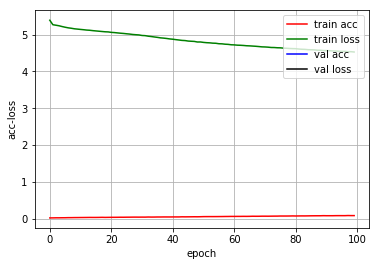

In [2]:
history = LossHistory()
#lstm-----
modellstm=build_model_lstm()
modellstm.summary()
y = np.concatenate([Y_train, Y_test])
modellstm.fit(datasetfix, y,epochs=100,batch_size=32, callbacks=[history])
# modellstm.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100,batch_size=32, callbacks=[history])
history.loss_plot('epoch')

In [ ]:
import math
def Dist_Error(pred,real):
    errors=np.abs(pred-real)
    result=[math.sqrt(math.pow(i[0],2)+math.pow(i[1],2))for i in errors]
    return np.array(result)
testRe=modellstm.predict_classes(X_test)
zone_number = 51
zone_letter = 'R'
testRe=testRe.reshape(-1)
y_test_utm=np.array(y_test_utm).reshape(-1,2)

testFi=[[grid[i][0], grid[i][1]] for i in testRe]

In [ ]:
errors=Dist_Error(np.array(testFi),np.array(y_test_utm))
errors=np.array(errors)
print(np.median(errors))
print(np.mean(errors))
print(np.sort(errors)[int(len(errors)*0.9)])

In [ ]:
x = np.arange(0,np.max(errors))
error_y = [len(errors[errors < i])/len(errors) for i in x]
plt.plot(x, error_y)

In [3]:
datatest = pd.read_csv('testfix.csv')
traj=datatest['TrajID'].values

dataset = [
    np.array([[mr[4:9],
               mr[9:14],
               mr[14:19],
               mr[19:24],
               mr[24:29],
               mr[29:34]]]).T for mr in datatest.values
]

dataset = np.array(dataset)
predict=model.predict(dataset)

In [4]:
predict=pd.DataFrame(predict)
predict['TrajID']=traj
tra=predict["TrajID"].unique()
datasetL=[]
labelsetL=[]
for i in tra:
       x=predict[predict["TrajID"]==i]
       value=[mr[0:891]for mr in x.values]
       datasetL.append(value)
print(np.shape(datasetL))

(70,)


In [5]:
datasetfix=[]
traj_id=[]
for i in range(len(datasetL)):
       count=len(datasetL[i])-maxleng+1
       for j in range(count):
            datasetfix.append(datasetL[i][j:j+maxleng])
            traj_id.append(i)
datasetfix=np.array(datasetfix)
print(datasetfix.shape)

(2120, 6, 891)


In [6]:
y_pred = modellstm.predict_classes(datasetfix)

In [7]:
print(y_pred.shape)

(2120, 6)


In [8]:
import math
def traj_merge(traj_id,trajs):
    maxleng=len(trajs[0])
    last=-1
    result=[]
    for i in range(len(traj_id)):
        if traj_id[i]!=last:
            result+=trajs[i]
            last=traj_id[i]
        else:
            result.append(trajs[i][maxleng-1])
    return result

In [9]:
y_p = traj_merge(traj_id,y_pred.tolist())
print(np.shape(y_p))

(2470,)


In [10]:
import utm
zone_number = 51
zone_letter = 'R'
y_final = [[utm.to_latlon(grid[i][0], grid[i][1], zone_letter=zone_letter, zone_number=zone_number)[1],
           utm.to_latlon(grid[i][0], grid[i][1], zone_letter=zone_letter, zone_number=zone_number)[0]] for i in y_p]
y_final = np.array(y_final)
df_pred = pd.DataFrame(data={'Longitude':y_final[:,0], 'Latitude':y_final[:,1]})
df_pred.to_csv('pred5.csv', index=False)
print('success')

success
